In [23]:
######################################################################
##################### SET SEED #######################
import torch
import numpy as np
import random

def set_seed(seed):
    # Python's built-in random generator
    random.seed(seed)
    
    # NumPy's random generator
    np.random.seed(seed)
    
    # PyTorch's random generator (CPU)
    torch.manual_seed(seed)
    
    # If you are using GPUs
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # If you're using multiple GPUs
        
    # Make CUDA deterministic (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Example usage
set_seed(42)
######################################################################

In [12]:
import pandas as pd

df_cc = pd.read_csv('./analysis_sheets/final_classified_samples_with_concept_gradients.csv')
df_mc = pd.read_csv('./analysis_sheets/final_misclassified_samples_with_concept_gradients.csv')

In [13]:
pd.set_option('display.max_colwidth', None)
df_cc.sample(10)

,Unnamed: 0,sentence,target_logits,concept_logits,concept_gradient,label,concept_label,tcav_score2
812,812,“personal attacks” on judges who blocked the administration’s first travel ban were “out of all bounds of civic and persuasive discourse.”\n\nWhy on earth would that be. Every decision maker is subject to personal criticism for their decision. Do the judges believe that they are oracles from God?,[[0.9671235 0.03287651]],[[0.5436294 0.02016822 0.2701553 0.46307078 0.03452519]],[[-0.04270843 -0.21364383 -0.12085158 -0.10977306 -0.23991667]],0,[[0 0 0 0 0]],"[-0.08191304, -0.07248733, -0.12390038, -0.08451594, -0.05713203]"
916,916,Oh the half orangutan is threatening to clean house alright. He says that if he can't do a White House makeover he's going to live in his bankrupt Trump penthouse. Keep 'em all in the penthouse. Good riddance.,[[0.32306862 0.6769314 ]],[[0.1002854 0.02508443 0.16310653 0.7124319 0.09668618]],[[0.03455093 0.02754967 0.03152949 0.05281863 0.02827368]],1,[[0 1 0 1 0]],"[0.07920141, 0.05130164, 0.20633397, 0.12203404, 0.0499733]"
339,339,I now hate Canada. \n\nI already hated Justin Turdeau,[[0.12852861 0.87147135]],[[0.3738079 0.08811272 0.90165204 0.8751658 0.637835 ]],[[0.05910993 0.02850544 0.14233337 0.13589741 0.09538251]],1,[[1 0 0 1 1]],"[0.0743716, 0.04591805, 0.18898252, 0.11009905, 0.04476108]"
192,192,You have history upside down and inside out. Are you talking about the Missiles to Megawatts program where the US bought uranium FROM Russia to power OUR country? \n\nhttps://en.wikipedia.org/wiki/Megatons_to_Megawatts_Program\n\nThat program was widely praised as a swords-to-plowshares type of initiative that was beneficial and helped reduce the aging nuclear stockpile. \n\nIt's as if your facts got put in a blender and you typed what poured out.,[[0.9942966 0.00570338]],[[0.01401022 0.0130657 0.05647927 0.13248393 0.03590261]],[[-0.16460182 -0.1111301 -0.0890817 -0.09803057 -0.05719401]],0,[[0 0 0 0 0]],"[-0.06722722, -0.05753541, -0.09889112, -0.06018158, -0.04677019]"
203,203,"OMG a new couple to have drinkies in Ottawa. They will be on the top of all the wannabe's ""dinner with"" lists. Hopefully they won't be here long and have to pay for their basketball tickets..... BWWAAA",[[0.9818428 0.01815715]],[[0.0306914 0.02783251 0.06326621 0.18525456 0.02498801]],[[-0.12071782 -0.08380055 -0.09912985 -0.09976964 -0.09428723]],0,[[0 0 0 0 0]],"[-0.08143159, -0.07067852, -0.12199756, -0.07815488, -0.05584906]"
778,778,Immigration reform is long overdue. Keep the trash out!,[[0.00583788 0.99416214]],[[0.7848538 0.17859328 0.7178583 0.97626877 0.5024752 ]],[[0.04564289 0.01739626 0.05198402 0.12462932 0.0441395 ]],1,[[1 0 0 1 1]],"[0.04116311, 0.02348391, 0.10717921, 0.07794461, 0.02151592]"
532,532,"I do appreciate those who are willing to run for office. Those of us out here who tend to introversion and recoil at the idea of spending months hat in hand looking for votes and money are grateful that there are those who have the talents and interest to so engage.\nOf course, if we had publicly funded elections, maybe funded by a national lottery with half the profits going to homeless shelters and half going to support elections, we would be able to have more people afford to run for office.\nOur electoral system is just nuts, starting with the electoral college and including the ""money is speech"" thing, where special interests with deep pockets and foreign interests dominate the political world. \nKind of hard to have a sense that low income Americans are able to raise our voices loud enough to be heard. Rich speech drowns out the cries of the lost and abandoned.\nGo Bernie.\nHugh Massengill, Eugene",[[0.9287992 0.07120074]],[[0.1791449 0.01726564 0.10809845 0.6230664 0.02046072]],[[-0.10067055 -0.18925391 -0.13824992 -0.06440315 -0.2206178 ]],0,[[0 0 0 0 0]],"[-0.08895343, -0.07572296, -0.14022194, -0.09104908, -0.06228541]"
67,67,Absolutely. We have some idiot drivers around here. Speeders a

In [14]:
import ast

def clean_and_parse_gradient(example):
    if isinstance(example, str):
        # Replace multiple spaces and commas, remove invalid characters, and ensure proper list structure
        cleaned_example = example.replace(' ', ',').replace(',,', ',').replace('[,', '[').replace(',]', ']')
        try:
            return ast.literal_eval(cleaned_example)  # Parse into a Python list
        except:
            return None  # Return None if parsing fails
    return example

df_cc['concept_gradient'] = df_cc['concept_gradient'].apply(clean_and_parse_gradient)
df_mc['concept_gradient'] = df_mc['concept_gradient'].apply(clean_and_parse_gradient)
df_cc['tcav_score2'] = df_cc['tcav_score2'].apply(clean_and_parse_gradient)
df_mc['tcav_score2'] = df_mc['tcav_score2'].apply(clean_and_parse_gradient)
df_cc.shape, df_mc.shape

((1413, 8), (232, 8))

In [15]:
import pandas as pd
import numpy as np
from collections import defaultdict

def process_data(df, label):
    concepts = ['obscene', 'threat', 'sexual_explicit', 'insult', 'identity_attack']
    result = defaultdict(list)
    
    for i, concept in enumerate(concepts):
        scores = df[df.label == label]['tcav_score2'].apply(lambda x: x[i])
        result[concept] = np.mean(scores)
    
    return dict(result)

data = {
    'Category': ['obscene', 'threat', 'sexual_explicit', 'insult', 'identity_attack'],
    'df_cc.label==0': list(process_data(df_cc, 0).values()),
    'df_mc.label==0': list(process_data(df_mc, 0).values()),
    'df_cc.label==1': list(process_data(df_cc, 1).values()),
    'df_mc.label==1': list(process_data(df_mc, 1).values())
}

df_result = pd.DataFrame(data)
df_result.head()

,Category,df_cc.label==0,df_mc.label==0,df_cc.label==1,df_mc.label==1
0,obscene,-0.073113,0.016186,0.048393,0.065288
1,threat,-0.061446,-0.014405,0.028681,0.035683
2,sexual_explicit,-0.127778,0.048258,0.111413,0.132550
3,insult,-0.068115,-0.010854,0.079441,0.064056
4,identity_attack,-0.056969,-0.005276,0.024179,0.050601


In [16]:
import pandas as pd
import numpy as np
from collections import defaultdict

def process_data(df, label):
    concepts = ['obscene', 'threat', 'sexual_explicit', 'insult', 'identity_attack']
    result = defaultdict(list)
    counts = defaultdict(int)
    
    for i, concept in enumerate(concepts):
        scores = df[df.label == label]['concept_gradient'].apply(lambda x: x[0][i] if x is not None and len(x) > 0 else None)
        scores = scores.dropna()  
        if len(scores) > 0:
            result[concept] = np.mean(scores)
            counts[concept] = len(scores)
        else:
            result[concept] = np.nan 
            counts[concept] = 0
    
    return dict(result), dict(counts)

data = {
    'Category': ['obscene', 'threat', 'sexual_explicit', 'insult', 'identity_attack'],
}

counts = {
    'Category': ['obscene', 'threat', 'sexual_explicit', 'insult', 'identity_attack'],
}

for df_name, df in [('df_cc', df_cc), ('df_mc', df_mc)]:
    for label in [0, 1]:
        means, sample_counts = process_data(df, label)
        column_name = f'{df_name}.label=={label}'
        data[column_name] = list(means.values())
        counts[column_name] = list(sample_counts.values())

# Create DataFrames
df_result = pd.DataFrame(data)
df_counts = pd.DataFrame(counts)

counts

{'Category': ['obscene',
  'threat',
  'sexual_explicit',
  'insult',
  'identity_attack'],
 'df_cc.label==0': [644, 644, 644, 644, 644],
 'df_cc.label==1': [649, 649, 649, 649, 649],
 'df_mc.label==0': [67, 67, 67, 67, 67],
 'df_mc.label==1': [146, 146, 146, 146, 146]}

In [17]:
 df_result.head()

,Category,df_cc.label==0,df_cc.label==1,df_mc.label==0,df_mc.label==1
0,obscene,-0.142837,0.045716,-0.030136,0.059352
1,threat,-0.092244,0.030114,-0.023835,0.042106
2,sexual_explicit,-0.108647,0.054480,-0.021381,0.019493
3,insult,-0.116186,0.091267,-0.037597,0.065651
4,identity_attack,-0.066294,0.045645,-0.009890,0.040062


In [18]:
# mapping for idx2name for gradient
import numpy as np

idx2name = {
    0: 'obscene', 
    1: 'threat', 
    2: 'sexual_explicit', 
    3: 'insult', 
    4: 'identity_attack'
}
# iterate through the dataframe
sentences = {}
for i, row in df_cc[df_cc.label==1].iterrows():
    # get the concept gradient and pick the top2
    # print(row['concept_gradient'])
    try:
        indices = np.argsort(row['concept_gradient'])[0][-2:][::-1]
        # print(indices)
        top_2_concepts = tuple(idx2name[idx] for idx in indices)
        # top_2_concepts = tuple(sorted(top_2_concepts))
        # Collect the sentences
        if top_2_concepts not in sentences:
            sentences[top_2_concepts] = []
        sentences[top_2_concepts].append(row['sentence'])
    except:
        continue

print(sentences.keys())
# sentences[('obscene', 'insult')]
# sentences[('sexual_explicit', 'insult')]
# sentences[('insult', 'obscene')]
sentences[('obscene', 'sexual_explicit')]

dict_keys([('insult', 'identity_attack'), ('insult', 'obscene'), ('insult', 'sexual_explicit'), ('sexual_explicit', 'insult'), ('identity_attack', 'threat'), ('threat', 'insult'), ('obscene', 'identity_attack'), ('sexual_explicit', 'identity_attack'), ('identity_attack', 'sexual_explicit'), ('obscene', 'insult'), ('identity_attack', 'insult'), ('insult', 'threat'), ('threat', 'identity_attack'), ('threat', 'obscene'), ('identity_attack', 'obscene'), ('threat', 'sexual_explicit'), ('obscene', 'sexual_explicit'), ('sexual_explicit', 'obscene')])


['you are going to be sent to a home for the stupid in 18 months if you keep spewing that stupdiity.',
 '2 fucking charges of 1st degree and 1 for second degree for a chicken really popo woooow must be a slow day',
 "This wretched LOSER of a 'woman' - Hillary Clinton - is a self-absorbed, psycho NUT JOB who should be locked up in prison for all of the innocent lives lost and the corruption that she is PERSONALLY RESPONSIBLE and LIABLE for!",
 'What a a repulsive psychopath. What an absolute scumbag. This animal needs to be removed before it can do any more damage, His support supporters are truly the scum of the Earth. This is what the 25th Amendment is there for. This talking pile of garbage is threatening the the whole country now,']

In [26]:
# mapping for idx2name for gradient
import numpy as np

idx2name = {
    0: 'obscene', 
    1: 'threat', 
    2: 'sexual_explicit', 
    3: 'insult', 
    4: 'identity_attack'
}
# iterate through the dataframe
sentences = {}
for i, row in df_cc[df_cc.label==1].iterrows():
    # get the concept gradient and pick the top2
    # print(row['concept_gradient'])
    try:
        indices = np.argsort(row['concept_gradient'])[0][-1:][::-1]
        # print(indices)
        top_2_concepts = tuple(idx2name[idx] for idx in indices)
        # top_2_concepts = tuple(sorted(top_2_concepts))
        # Collect the sentences
        if top_2_concepts not in sentences:
            sentences[top_2_concepts] = []
        sentences[top_2_concepts].append(row['sentence'])
    except:
        continue

print(sentences.keys())
sentences[('threat',)]
sentences[('insult',)]
# sentences[('sexual_explicit',)]
# # sentences[('insult', 'obscene')]
# sentences[('identity_attack', 'obscene')]

dict_keys([('insult',), ('sexual_explicit',), ('identity_attack',), ('threat',), ('obscene',)])


["It's an idiotic system offering only one moronic choice. It lacks the integrity to offer a True/False choice, and is essentially meaningless. A lie politely expressed is bogus civility.",
 "I WAS RAPED BY AMY DEMBOSKI\n\nLet's talk about it, either validate or disprove it",
 "I guess it's hard to keep an old race-baiting hypocrite like tangreedo down...\nHowever, if he doesn't understand the basic elements of the First Amendment, then he's not fit to hold any office. Let him waste more money running - as long as he's never voted in again.",
 'I find it hard to take this congresswoman clown serious, she looks like a transgendered cowboy/girl. What a joker!',
 'Sounds like a loser.  Or at least, an angry loser, lol',
 'Ohhh hahahahahahahaha! Another loony fairy tale from the big, fat, orange buffoon.',
 "Alaska Airlines is a private company.  They have the right to deal with unruly passengers as they see fit.  Here they sided with their employee and threw the jerk off.  Good for the pi

In [26]:
df_mc[df_mc.label==1].shape

(161, 8)

In [14]:
for label_tuple, sentence_list in sentences.items():
    label = label_tuple[0]  # Extract the label
    filename = f"{label}_sentences.txt"
    with open(filename, 'w', encoding='utf-8') as file:
        for sentence in sentence_list:
            file.write(sentence + '\n')
    print(f"Sentences for category '{label}' have been written to {filename}")


Sentences for category 'insult' have been written to insult_sentences.txt
Sentences for category 'sexual_explicit' have been written to sexual_explicit_sentences.txt
Sentences for category 'identity_attack' have been written to identity_attack_sentences.txt
Sentences for category 'threat' have been written to threat_sentences.txt
Sentences for category 'obscene' have been written to obscene_sentences.txt


In [2]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create the DataFrame with the provided data
data = {
    'Profanity_Word': [
        'Trumplethinskin', 'fake', 'trashy', 'sexually', 'hoosegow', 'Reichstag',
        'Nazi', 'ISIS', 'Islamophobia', 'Dumbya', 'Supremacists', 'Slovenian',
        'Homo', 'neo-BroederBond', 'Boggle', 'lifeofthedelayed', 'pussy', 'Yikes',
        'Nazis', 'Buffoon-in-Chief', 'Ob0ngo', 'TORTURE', 'Sewer', 'looney',
        'Gay', 'takemyabortionpill', 'beheading', 'CUT', 'treasonous', 'billionaire',
        'mentally', 'RACIST', 'D--bag', 'Rotten', 'genes', 'hot', 'Soros', 'sexist',
        'narrow-minded', 'idiots', 'racists', 'hate', 'degenerate', 'gunmericans',
        'turds', 'misogyny', 'Communist', 'white supremacists', 'Twitler', 'sexism',
        'Trumpenfuhrer', 'TERRORISTS', 'raped', 'gay-bashing', 'fountains'
    ],
    'Count': [
        1, 4, 1, 1, 1, 1, 3, 4, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 4, 0, 1, 3, 2, 1, 5, 7, 1, 2, 1, 1, 2, 3, 1, 2,
        5, 7, 1, 1, 1, 1, 1, 2, 1, 1, 1, 4, 1, 1, 1
    ]
}

df = pd.DataFrame(data)

# Create a dictionary of word frequencies
word_freq = dict(zip(df['Profanity_Word'], df['Count']))

# Generate the word cloud
wordcloud = WordCloud(
    width=2400,  # Increased width for higher resolution
    height=1200,  # Increased height for higher resolution
    background_color='white',
    colormap='hot',  # Color map for the words
    max_font_size=300,  # Increased max font size for clarity
    relative_scaling=0.5,
    normalize_plurals=True
).generate_from_frequencies(word_freq)

# Save the word cloud to a high-resolution PNG file
output_filename_png = 'profanity_word_cloud.png'
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Profanity Word Cloud', fontsize=24)
plt.tight_layout(pad=0)
plt.savefig(output_filename_png, format='png', dpi=300, bbox_inches='tight')
plt.close()  # Close the figure to free memory


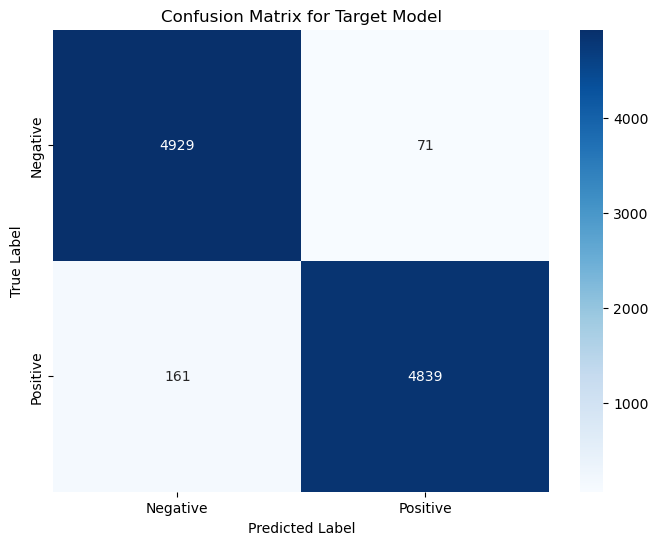

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrix data
conf_matrix = np.array([[4929, 71], 
                        [161, 4839]])

# Labels for the axes
labels = ['Negative', 'Positive']  # Replace these with the actual class labels if needed

# Create the heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)

# Set axis titles
plt.title('Confusion Matrix for Target Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.savefig('target_cm.png', format='png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()
